## Paquetes

In [1]:
import pandas as pd
import openpyxl
from tqdm import tqdm
import unidecode
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import warnings
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math
from operator import itemgetter

import unidecode
import string
import re
from fuzzywuzzy import fuzz
import os

Parametros

In [17]:
carpeta = "OUT_1_DATA_ELECTORAL_PROCESADA"

if not os.path.exists(carpeta):
    os.makedirs(carpeta)

In [7]:
df = pd.read_excel("INPUT_1_DATA_ELECTORAL/Partidos_Electorales.xlsx")

## Procesamiento General

Extraer tipos de movimientos

In [8]:
# Función para extraer texto después del primer punto
def extract_after_dash(s):
    parts = s.split('-', 1)  # divide la cadena en dos partes en el dash
    return parts[0] if len(parts) > 1 else s  # devuelve la segunda parte si existe

df["nombre_partido_dash"] = df["nombre_partido"].apply(extract_after_dash)

In [9]:
df["tipo"] = df["nombre_partido"].apply(lambda x: x.split(" ")[0])

tipos = ['COALICION', 'MOVIMIENTO', 'G.S.C', 'UNIDOS', 'ASOCIACION', 'CONSEJO',
       'PARTIDO', 'FUNDACION', 'ALIANZA', 'CORPORACION', 'ORGANIZACION', 'UNIDAD', 'COMPROMISO',
       'FUERZA', 'UNION', 'PRIMERO', 'CABILDO', 'ACCION', 'CONVERGENCIA', 'PACTO', 'FRENTE',
       'INTEGRACION']

df["tipo"] = df["tipo"].apply(lambda x: x if x in tipos else "OTRO")

### Procesamiento de Coaliciones

In [10]:
coal = df[df.tipo == "COALICION"]   #MOVIMIENTOS DE COALICIONES
nocoal = df[df.tipo != "COALICION"] #MOVIMIENTOS QUE NO SON COALICIONES

Miembros de coaliciones

In [11]:
def extract_after_dot(s):
    parts = s.split('.', 1)
    return parts[1] if len(parts) > 1 else None

coal["miembros"] = coal["nombre_partido"].apply(extract_after_dot)

Limpieza de los miembros: nombre de partidos

In [12]:
# Diccionario de reemplazos
replacements = {
    "PARTIDO MIRA": "MOVIMIENTO INDEPENDIENTE DE RENOVACION ABSOLUTA : MIRA",
    "PARTIDO AICO": "MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA : AICO",
    "MOVIMIENTO AICO": "MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA : AICO",
    "MAIS": "MOVIMIENTO ALTERNATIVO INDIGENA Y SOCIAL : MAIS",
    "PARTIDO MAIS": "MOVIMIENTO ALTERNATIVO INDIGENA Y SOCIAL : MAIS",
    "MOVIMIENTO MAIS": "MOVIMIENTO ALTERNATIVO INDIGENA Y SOCIAL : MAIS",
    "SOCIAL : MAIS": "MOVIMIENTO ALTERNATIVO INDIGENA Y SOCIAL : MAIS",
    "SOCIAL:MAIS": "MOVIMIENTO ALTERNATIVO INDIGENA Y SOCIAL : MAIS",
    "PARTIDO FARC": "FUERZA ALTERNATIVA REVOLUCIONARIA DEL COMUN FARC : PARTIDO COMUNES",
    "PARTIDO DE LA U": "PARTIDO SOCIAL DE UNIDAD NACIONAL",
    "CAMBIO RADICAL": "PARTIDO CAMBIO RADICAL",
    "MOIR": "MOVIMIENTO OBRERO INDEPENDIENTE Y REVOLUCIONARIO - MOIR",
    "ANAPO": "ALIANZA NACIONAL POPULAR - ANAPO",
    "UNION PATRIOTICA": "PARTIDO COLOMBIA HUMANA Y UNION PATRIOTICA",
    "MOVIMIENTO ALAS": "MOVIMIENTO ALAS EQUIPO COLOMBIA",
    "MIPOL": "MOVIMIENTO DE INTEGRACION POPULAR - MIPOL",
    "ADA": "MOVIMIENTO ALIANZA DEMOCRATICA AFROCOLOMBIANA - ADA",
    "MOVIMIENTO ASI": "MOVIMIENTO ALIANZA SOCIAL INDIGENA - ASI"
}

# Aplicar reemplazos usando un bucle
for old, new in replacements.items():
    coal['miembros'] = coal['miembros'].apply(lambda x: x.replace(old, new) if isinstance(x, str) else x)

Limpieza de los miembros: limpieza general

In [13]:
# Reemplaza cualquier texto entre comillas dobles (incluidas las comillas) por una cadena vacía en la columna 'miembros'
coal['miembros'] = coal['miembros'].str.replace(r'\".*?\"', '', regex=True)


# Define una función para recortar una cadena después de la última letra (a-zA-Z)
def trim_after_last_letter(s):
    # Si el input no es una cadena, devuélvelo tal cual
    if not isinstance(s, str):
        return s
    # Busca el último carácter que sea una letra seguido de cualquier carácter que no sea una letra
    match = re.search('[a-zA-Z][^a-zA-Z]*$', s)
    # Si se encuentra una coincidencia, devuelve la cadena hasta (y incluyendo) la última letra
    if match:
        return s[:match.start() + 1]
    # Si no hay coincidencia, devuelve la cadena tal cual
    return s

# Aplica la función trim_after_last_letter a cada elemento de la columna 'miembros' 
coal['miembros'] = coal['miembros'].apply(trim_after_last_letter)

# Reemplaza todas las ocurrencias de "Y" por "-" en la columna 'miembros'
coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("Y", "-") if isinstance(x, str) else x)

In [14]:
#Lista de miembros en formato de lista
coal["miembros_split"] = coal['miembros'].apply(lambda x: [item.lstrip() for item in x.split("-")] if isinstance(x, str) else x)

¿Cómo se ve la base?

In [15]:
coal.head(8)

,codigo_partido,nombre_partido,nombre_partido_dash,tipo,miembros,miembros_split
221,20150172,COALICION ALCADIA DE MORALES-CAU. PARTIDO CON...,COALICION ALCADIA DE MORALES,COALICION,PARTIDO CONSERVADOR - PARTIDO MOVIMIENTO ALT...,"[PARTIDO CONSERVADOR , PARTIDO MOVIMIENTO ALTE..."
222,20190090,COALICION ALCALDIA ABEJORRAL-ANT. PARTIDO LIB...,COALICION ALCALDIA ABEJORRAL,COALICION,PARTIDO LIBERAL - PARTIDO SOCIAL DE UNIDAD N...,"[PARTIDO LIBERAL , PARTIDO SOCIAL DE UNIDAD NA..."
223,20000296,COALICION ALCALDIA ABREGO-NORTE. PARTIDO LIBE...,COALICION ALCALDIA ABREGO,COALICION,PARTIDO LIBERAL - PARTIDO CONSERVADOR,"[PARTIDO LIBERAL , PARTIDO CONSERVADOR]"
224,20000132,COALICION ALCALDIA ALBAN-NARIÑO. CON. INDEPEN...,COALICION ALCALDIA ALBAN,COALICION,CON. INDEPENDIENTE - PARTIDO CONSERVADOR,"[CON. INDEPENDIENTE , PARTIDO CONSERVADOR]"
225,20000318,COALICION ALCALDIA ALCALA-VALLE. VAMOS COLOMB...,COALICION ALCALDIA ALCALA,COALICION,VAMOS COLOMBIA - PARTIDO COMUNAL - COMUNITARIO,"[VAMOS COLOMBIA , PARTIDO COMUNAL , COMUNITARIO]"
226,20000233,COALICION ALCALDIA ALMAGUER-CAUCA. PARTIDO LI...,COALICION ALCALDIA ALMAGUER,COALICION,PARTIDO LIBERAL - PARTIDO CONSERVADOR,"[PARTIDO LIBERAL , PARTIDO CONSERVADOR]"
227,20000226,COALICION ALCALDIA ALMEIDA-BOYACA. PARTIDO LI...,COALICION ALCALDIA ALMEIDA,COALICION,PARTIDO LIBERAL - PARTIDO CONSERVADOR,"[PARTIDO LIBERAL , PARTIDO CONSERVADOR]"
228,20000160,COALICION ALCALDIA ALVARADO-TOLIMA. CAMBIO RA...,COALICION ALCALDIA ALVARADO,COALICION,PARTIDO CAMBIO RADICAL - MOVIMIENTO UNIONISTA,"[PARTIDO CAMBIO RADICAL , MOVIMIENTO UNIONISTA]"


### Estudio de Frecuencias

Partidos de las frecuencias

In [16]:
# Crear una lista con los elementos de coal.miembros_split
l = []
for i in coal.miembros_split:
    if isinstance(i, list):
        for e in i:
            l.append(e.lstrip())

# Convertir la lista l en una Serie
serie = pd.Series(l)

# Contar la frecuencia de cada elemento
frecuencias = serie.value_counts()
frecuencias = frecuencias.reset_index()
frecuencias.columns = ["partido_coal", "frecuencia"]

# Crear columna 'tipo' basada en el primer elemento de 'partido_coal'
frecuencias["tipo"] = frecuencias["partido_coal"].apply(lambda x: x.split(" ")[0] if isinstance(x, str) else x)

# Función para encontrar el mejor match usando Fuzzy Matching
def match_with_highest_ratio(partido_name, no_coal_column):
    ratios = [fuzz.partial_ratio(partido_name, no_coal_name) for no_coal_name in no_coal_column]
    max_index = ratios.index(max(ratios))
    return no_coal_column.iloc[max_index]

# Aplicar la función a cada fila en frecuencias para encontrar mejores matches
frecuencias["best_match_partido"] = frecuencias.apply(lambda row: match_with_highest_ratio(row["partido_coal"], nocoal[nocoal.tipo=="PARTIDO"]["nombre_partido_dash"]) if row["tipo"] == "PARTIDO" else np.nan , axis=1)
frecuencias["best_match_otros"] = frecuencias.apply(lambda row: match_with_highest_ratio(row["partido_coal"], nocoal[nocoal.tipo!="X"]["nombre_partido_dash"]) if row["tipo"] != "PARTIDO" else np.nan, axis=1)

# Combinar los mejores matches de partidos y otros
frecuencias["match"] = frecuencias["best_match_partido"].fillna(frecuencias["best_match_otros"])

Revisión manual

In [18]:
frecuencias.to_excel(f"{carpeta}//revisión_manual.xlsx", index = False) #REVISIÓN GENERAL
frecuencias = pd.read_excel(f"{carpeta}//revisión_manual_modificado.xlsx") #REVISIÓN MANUAL (PARA HACER CAMBIOS)

In [19]:
frecuencias = frecuencias[["partido_coal", "match"]]

In [20]:
frecuencias.head()

,partido_coal,match
0,MCC,MOVIMIENTO CIVICO D.F.G.
1,MC,MOVIMIENTO CIVICO D.F.G.
2,MOVIMIENTO C,MOVIMIENTO CIVICO D.F.G.
3,AICO,MOVIMIENTO CIVICO D.F.G.
4,CC,MOVIMIENTO CIVICO D.F.G.


Pegar a coaliciones

Todo el procesamiento anterior se hizo para limpiar y homogenizar los nombres de los partidos dentro de las coaliciones. Así, finalmente asignarle los códigos de la base misma a cada partido o movimiento.

In [21]:
coal["miembros_clean"] = coal["miembros_split"].copy()

In [22]:
reemplazo_dict = dict(zip(frecuencias['partido_coal'], frecuencias['match']))


# Función que reemplaza los valores basados en el diccionario y maneja valores None
def reemplazar_valores(lista):
    if lista is None:
        return None
    return [reemplazo_dict.get(item, item) for item in lista]

# Aplicar la función a la columna 'miembros_clean'
coal['miembros_clean'] = coal['miembros_clean'].apply(reemplazar_valores)


# 1. Crear diccionario de mapeo desde df
mapeo_dict = df.set_index('nombre_partido_dash')['codigo_partido'].to_dict()

# 2. Función para mapear valores en las listas usando el diccionario mapeo_dict
def mapear_valores(lista):
    if lista is None:
        return None
    return [mapeo_dict.get(item, item) for item in lista]

# Aplicar la función a la columna 'miembros_clean' y guardar en 'miembros_code'
coal['miembros_code'] = coal['miembros_clean'].apply(mapear_valores)


# 1. Crear diccionarios de mapeo desde df
mapeo_dict_dash = df.set_index('nombre_partido_dash')['codigo_partido'].to_dict()
mapeo_dict_nombre = df.set_index('nombre_partido')['codigo_partido'].to_dict()

# 2. Función para mapear valores en las listas usando ambos diccionarios
def mapear_valores(lista):
    if lista is None:
        return None
    
    nuevos_valores = []
    for item in lista:
        # Intenta mapear usando nombre_partido_dash
        nuevo_valor = mapeo_dict_dash.get(item, None)
        
        # Si no es exitoso, intenta mapear usando nombre_partido
        if nuevo_valor is None:
            nuevo_valor = mapeo_dict_nombre.get(item, item)
        
        nuevos_valores.append(nuevo_valor)
    
    return nuevos_valores

# Aplicar la función a la columna 'miembros_clean' y guardar en 'miembros_code'
coal['miembros_code'] = coal['miembros_clean'].apply(mapear_valores)


def eliminar_no_numericos_o_nan(lista):
    if lista is None:
        return None
    return [item for item in lista if isinstance(item, (int, float)) and not math.isnan(item)]

coal['miembros_code'] = coal['miembros_code'].apply(eliminar_no_numericos_o_nan)


def reemplazar_lista_vacia(row):
    if not row['miembros_code']:
        return [row['codigo_partido']]
    return row['miembros_code']

coal['miembros_code'] = coal.apply(reemplazar_lista_vacia, axis=1)

## Procesamiento de las no coaliciones

In [23]:
nocoal["miembros"] =  nocoal["nombre_partido"]
nocoal["miembros_split"] =  nocoal["nombre_partido"]
nocoal["miembros_clean"] =  nocoal["nombre_partido"].apply(lambda x: [x])
nocoal["miembros_code"] =  nocoal["codigo_partido"].apply(lambda x: [x])

## Dataframe final

In [24]:
dff = pd.concat([nocoal, coal])
dff = dff[["codigo_partido", "nombre_partido", "tipo", "miembros_code", "miembros_clean"]]

In [26]:
dff.to_excel(f"{carpeta}//Partidos_Electorales_Wide.xlsx", index = False)
dff.explode('miembros_code').to_excel(f"{carpeta}//Partidos_Electorales_Long.xlsx", index = False) #LONG (CADA FILA ES UN MIEMBRO DE COALICIÓN Y LAS COALICIONES PUEDEN ESTAR )

In [ ]:
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("PARTIDO MIRA", "MOVIMIENTO INDEPENDIENTE DE RENOVACION ABSOLUTA : MIRA") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("PARTIDO AICO", "MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA : AICO") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("MOVIMIENTO AICO", "MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA : AICO") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("MAIS", "MOVIMIENTO ALTERNATIVO INDIGENA Y SOCIAL : MAIS") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("PARTIDO MAIS", "MOVIMIENTO ALTERNATIVO INDIGENA Y SOCIAL : MAIS") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("MOVIMIENTO MAIS", "MOVIMIENTO ALTERNATIVO INDIGENA Y SOCIAL : MAIS") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("SOCIAL : MAIS", "MOVIMIENTO ALTERNATIVO INDIGENA Y SOCIAL : MAIS") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("SOCIAL:MAIS", "MOVIMIENTO ALTERNATIVO INDIGENA Y SOCIAL : MAIS") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("PARTIDO FARC", "FUERZA ALTERNATIVA REVOLUCIONARIA DEL COMUN FARC : PARTIDO COMUNES") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("PARTIDO DE LA U", "PARTIDO SOCIAL DE UNIDAD NACIONAL") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("CAMBIO RADICAL", "PARTIDO CAMBIO RADICAL") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("MOIR", "MOVIMIENTO OBRERO INDEPENDIENTE Y REVOLUCIONARIO - MOIR") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("ANAPO", "ALIANZA NACIONAL POPULAR - ANAPO") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("UNION PATRIOTICA", "PARTIDO COLOMBIA HUMANA Y UNION PATRIOTICA") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("ANAPO", "ALIANZA NACIONAL POPULAR - ANAPO") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("MOIR", "MOVIMIENTO OBRERO INDEPENDIENTE Y REVOLUCIONARIO - MOIR") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("MOVIMIENTO ALAS", "MOVIMIENTO ALAS EQUIPO COLOMBIA") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("MIPOL", "MOVIMIENTO DE INTEGRACION POPULAR - MIPOL") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("ADA", "MOVIMIENTO ALIANZA DEMOCRATICA AFROCOLOMBIANA - ADA") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("ADA ", "MOVIMIENTO ALIANZA DEMOCRATICA AFROCOLOMBIANA - ADA") if isinstance(x, str) else x)
# coal['miembros'] = coal['miembros'].apply(lambda x: x.replace("MOVIMIENTO ASI", "MOVIMIENTO ALIANZA SOCIAL INDIGENA - ASI") if isinstance(x, str) else x)

In [ ]:
# l = []
# for i in coal.miembros_split:
#     if isinstance(i, list):
#         for e in i:
#             l.append(e.lstrip())


# # Convertir la lista l en una Serie
# serie = pd.Series(l)

# # Contar la frecuencia de cada elemento
# frecuencias = serie.value_counts()
# frecuencias = frecuencias.reset_index()
# frecuencias.columns = ["partido_coal", "frecuencia"]


# frecuencias["tipo"] = frecuencias["partido_coal"].apply(lambda x: x.split(" ")[0] if isinstance(x, str) else x)


# def match_with_highest_ratio(partido_name, no_coal_column):
#     # Compara el partido_name con cada nombre en no_coal_column y almacena los ratios
#     ratios = [fuzz.partial_ratio(partido_name, no_coal_name) for no_coal_name in no_coal_column]

#     # Obtiene el índice del valor más alto
#     max_index = ratios.index(max(ratios))

#     # Devuelve el nombre de nombre_partido_dash con el ratio más alto
#     return no_coal_column.iloc[max_index]


# # Aplica la función a cada fila en frecuencias
# frecuencias["best_match_partido"] = frecuencias.apply(lambda row: match_with_highest_ratio(row["partido_coal"], nocoal[nocoal.tipo=="PARTIDO"]["nombre_partido_dash"]) if row["tipo"] == "PARTIDO" else np.nan , axis=1)
# frecuencias["best_match_otros"] = frecuencias.apply(lambda row: match_with_highest_ratio(row["partido_coal"], nocoal[nocoal.tipo!="X"]["nombre_partido_dash"]) if row["tipo"] != "PARTIDO" else np.nan, axis=1)
# frecuencias["match"] = frecuencias["best_match_partido"].fillna(frecuencias["best_match_otros"])# l = []
# for i in coal.miembros_split:
#     if isinstance(i, list):
#         for e in i:
#             l.append(e.lstrip())


# # Convertir la lista l en una Serie
# serie = pd.Series(l)

# # Contar la frecuencia de cada elemento
# frecuencias = serie.value_counts()
# frecuencias = frecuencias.reset_index()
# frecuencias.columns = ["partido_coal", "frecuencia"]


# frecuencias["tipo"] = frecuencias["partido_coal"].apply(lambda x: x.split(" ")[0] if isinstance(x, str) else x)


# def match_with_highest_ratio(partido_name, no_coal_column):
#     # Compara el partido_name con cada nombre en no_coal_column y almacena los ratios
#     ratios = [fuzz.partial_ratio(partido_name, no_coal_name) for no_coal_name in no_coal_column]

#     # Obtiene el índice del valor más alto
#     max_index = ratios.index(max(ratios))

#     # Devuelve el nombre de nombre_partido_dash con el ratio más alto
#     return no_coal_column.iloc[max_index]


# # Aplica la función a cada fila en frecuencias
# frecuencias["best_match_partido"] = frecuencias.apply(lambda row: match_with_highest_ratio(row["partido_coal"], nocoal[nocoal.tipo=="PARTIDO"]["nombre_partido_dash"]) if row["tipo"] == "PARTIDO" else np.nan , axis=1)
# frecuencias["best_match_otros"] = frecuencias.apply(lambda row: match_with_highest_ratio(row["partido_coal"], nocoal[nocoal.tipo!="X"]["nombre_partido_dash"]) if row["tipo"] != "PARTIDO" else np.nan, axis=1)
# frecuencias["match"] = frecuencias["best_match_partido"].fillna(frecuencias["best_match_otros"])

## Consejo

In [24]:
data_electoral_procesada = "OUT_1_DATA_ELECTORAL_PROCESADA"
partidos = pd.read_excel(f"{data_electoral_procesada}//Partidos_Electorales_Long.xlsx")

In [ ]:
carpeta = "7_GRAFICAS_RD"

if not os.path.exists(carpeta):
    os.makedirs(carpeta)

In [ ]:
# import matplotlib.pyplot as plt



NameError: name 'dd' is not defined

<Figure size 720x432 with 0 Axes>

In [ ]:
# d = df[df.date == año_t1]
# d["X"] = d[f"diferencia_{año_t1}"].copy()
# dd = d[["X"]].dropna()
# rdd = rddensity.rddensity(X=dd["X"])
# rddensity.rdplotdensity(rdd, dd["X"])

In [ ]:
# dependientes_list = df.columns[19:-3]
dependientes_list = df.columns[19:-3]

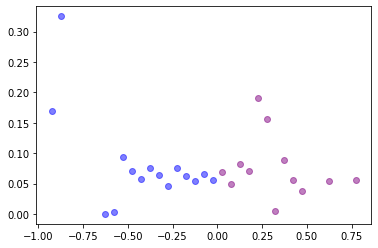

In [ ]:
plt.scatter(before_threshold['bin'], before_threshold['Y'], color='blue', alpha=0.5, label="Before threshold")
plt.scatter(after_threshold['bin'], after_threshold['Y'], color='purple', alpha=0.5, label="After threshold")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


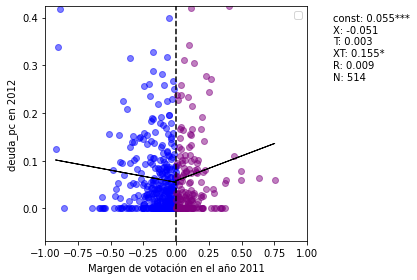

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


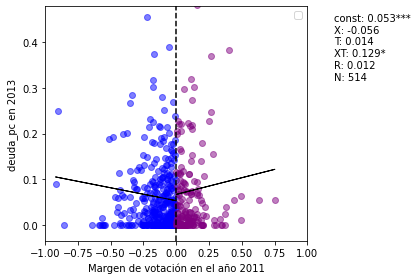

In [ ]:
for año in años_ev:
    for Y in dependientes_list:
        try:
            threshold = 0

            d = df[df.date == año]
            d["X"] = d[f"diferencia_{año_t1}"].copy()
            d["Y"] = d[Y]
            dd = d[[Y, "X"]].dropna()
            dd.columns = ["Y", "X"]
            dd = dd[np.abs(dd["X"])<=1]


            #VERIFICAR QUE ES EL MISMO COEFICIENTE
            dd['const'] = 1
            dd["T"] = dd["X"].apply(lambda x: 1 if x>=threshold else 0)

            # Crear la interacción
            dd['XT'] = dd['X'] * dd['T']
            model = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']])
            results = model.fit()
            sumario = results.summary2()

            #LO MISMO PERO CON EL COMANDO RD-ROBUST
            est1 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "uniform", all = True, h = 100, vce='hc0')
            est2 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "triangular", all = True, h = 100, vce = "hc0")

            N = sumario.tables[0].iloc[3,1]
            R = sumario.tables[0].iloc[6,1]

            coef_df = sumario.tables[1].loc[:,["Coef.", "P>|t|"]]
            coef_df['P>|t|'] = coef_df['P>|t|'].apply(significance)
            coef_df["coef"] = coef_df.apply(lambda row: str(round(row["Coef."],3))+row["P>|t|"], axis = 1)
            coef_df = coef_df[["coef"]]
            coef_df.loc["R"] = R
            coef_df.loc["N"] = N

            p = sumario.tables[1].loc["XT","P>|t|"]

            if p<0.1:

                maxy = dd["Y"].quantile(0.99)
                miny = dd["Y"].quantile(0.00)
            
                # Generar las predicciones del modelo
                dd['y_pred'] = results.predict(dd[['const', 'X', 'T', 'XT']])

                # Separar los datos para antes y después del umbral
                before_threshold = dd[dd['X'] < threshold]
                after_threshold = dd[dd['X'] >= threshold]

                # Graficar los datos reales
                plt.scatter(before_threshold['X'], before_threshold['Y'], color='blue', alpha=0.5)
                plt.scatter(after_threshold['X'], after_threshold['Y'], color='purple', alpha=0.5)

                # Graficar las predicciones del modelo
                plt.plot(before_threshold['X'], before_threshold['y_pred'], color='black', linewidth=1)
                plt.plot(after_threshold['X'], after_threshold['y_pred'], color='black', linewidth=1)

                # Añadir línea vertical en X=0
                plt.axvline(x=threshold, color='black', linestyle='--')

                # Títulos y etiquetas
                # plt.title("Gráfica de la regresión discontinua")
                plt.xlabel(f"Margen de votación en el año {año_t1}")
                plt.ylabel(f"{Y} en {año}")
                plt.legend()
                plt.xlim(-1,1)

                plt.gca().set_ylim(top=maxy)

                # # Asumiendo que quieres poner la leyenda en la esquina superior derecha
                # x_position = 1.3 * np.abs(plt.xlim()[1])  # 60% a lo largo del eje x
                # y_position = 0.9 * np.abs(plt.ylim()[1])  # 90% a lo largo del eje y

                # # Usar un loop para escribir cada coeficiente en la gráfica
                # for index, row in coef_df.iterrows():
                #     coef_string = f"{index}: {row['coef']}"
                #     plt.text(x_position, y_position, coef_string, fontsize=10)
                #     y_position -= 0.1 * plt.ylim()[1]  # Esto moverá cada entrada un 10% hacia abajo en el eje y


                # Definir la posición inicial en la esquina superior derecha.
                # (1, 1) representa la esquina superior derecha del eje.
                x_position = 1.1  # Justo a la derecha del eje
                y_position = 0.95  # Cerca de la parte superior del eje

                # Espaciado vertical entre las entradas de la leyenda.
                y_spacing = 0.05

                # Usar un loop para escribir cada coeficiente en la gráfica
                for index, row in coef_df.iterrows():
                    coef_string = f"{index}: {row['coef']}"
                    
                    plt.annotate(coef_string, 
                                xy=(x_position, y_position), 
                                xycoords='axes fraction', 
                                fontsize=10,
                                horizontalalignment='left',
                                verticalalignment='center')

                    # Mover la posición y hacia abajo para la siguiente entrada
                    y_position -= y_spacing

                plt.tight_layout()
                plt.savefig(f"{carpeta}//ELECCIONES_{año_t1}_{Y}_{año}", bbox_inches='tight')

                plt.show()
        except:
            None  

            

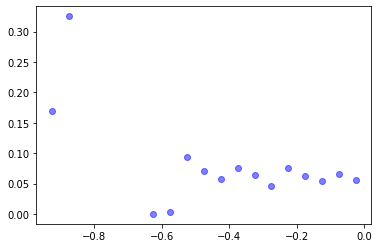

In [ ]:
plt.scatter(before_threshold['bin'], before_threshold['Y'], color='blue', alpha=0.5, label="Before threshold")

In [ ]:
grouped 

,bin,Y,y_pred
0,-0.975,NaN,NaN
1,-0.925,0.170080,0.104638
2,-0.875,0.325109,0.102328
3,-0.825,NaN,NaN
4,-0.775,NaN,NaN
5,-0.725,NaN,NaN
6,-0.675,NaN,NaN
7,-0.625,0.000000,0.089341
8,-0.575,0.002661,0.085323
9,-0.525,0.094200,0.082974


In [ ]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)

In [ ]:
for año in años_ev:
    for Y in dependientes_list:
        d = df[df.date == año]
        try:
            d["X"] = d[f"diferencia_{año_t1}"].copy()
            d["Y"] = d[Y]
            dd = d[[Y, "X"]].dropna()
            dd.columns = ["Y", "X"]
            dd = dd[np.abs(dd["X"])<=1]


            #VERIFICAR QUE ES EL MISMO COEFICIENTE
            dd['const'] = 1
            dd["T"] = dd["X"].apply(lambda x: 1 if x>=0 else 0)

            # Crear la interacción
            dd['XT'] = dd['X'] * dd['T']
            model = sm.OLS(dd['Y'], dd[['const', 'T']])
            results = model.fit()
            sumario = results.summary2()

            #LO MISMO PERO CON EL COMANDO RD-ROBUST
            est1 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "uniform", all = True, h = 100, vce='hc0')
            est2 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "triangular", all = True, h = 100, vce = "hc0")

            N = sumario.tables[0].iloc[3,1]
            R = sumario.tables[0].iloc[6,1]

            coef_df = sumario.tables[1].loc[:,["Coef.", "P>|t|"]]
            coef_df['P>|t|'] = coef_df['P>|t|'].apply(significance)
            coef_df["coef"] = coef_df.apply(lambda row: str(round(row["Coef."],3))+row["P>|t|"], axis = 1)
            coef_df = coef_df[["coef"]]
            coef_df.loc["R"] = R
            coef_df.loc["N"] = N

            p = sumario.tables[1].loc["XT","P>|t|"]

            if p<0.1:

                maxy = dd["Y"].quantile(0.99)
                miny = dd["Y"].quantile(0.00)
            
                # Generar las predicciones del modelo
                dd['y_pred'] = results.predict(dd[['const', 'T']])

                # Separar los datos para antes y después del umbral
                before_threshold = dd[dd['X'] < 0]
                after_threshold = dd[dd['X'] >= 0]

                # Graficar los datos reales
                plt.scatter(before_threshold['X'], before_threshold['Y'], color='blue', alpha=0.5)
                plt.scatter(after_threshold['X'], after_threshold['Y'], color='purple', alpha=0.5)

                # Graficar las predicciones del modelo
                plt.plot(before_threshold['X'], before_threshold['y_pred'], color='black', linewidth=1)
                plt.plot(after_threshold['X'], after_threshold['y_pred'], color='black', linewidth=1)

                # Añadir línea vertical en X=0
                plt.axvline(x=0, color='black', linestyle='--')

                # Títulos y etiquetas
                # plt.title("Gráfica de la regresión discontinua")
                plt.xlabel(f"Margen de votación en el año {año_t1}")
                plt.ylabel(f"{Y} en {año}")
                plt.legend()
                plt.xlim(-1,1)

                plt.gca().set_ylim(top=maxy)

                # # Asumiendo que quieres poner la leyenda en la esquina superior derecha
                # x_position = 1.3 * np.abs(plt.xlim()[1])  # 60% a lo largo del eje x
                # y_position = 0.9 * np.abs(plt.ylim()[1])  # 90% a lo largo del eje y

                # # Usar un loop para escribir cada coeficiente en la gráfica
                # for index, row in coef_df.iterrows():
                #     coef_string = f"{index}: {row['coef']}"
                #     plt.text(x_position, y_position, coef_string, fontsize=10)
                #     y_position -= 0.1 * plt.ylim()[1]  # Esto moverá cada entrada un 10% hacia abajo en el eje y


                # Definir la posición inicial en la esquina superior derecha.
                # (1, 1) representa la esquina superior derecha del eje.
                x_position = 1.1  # Justo a la derecha del eje
                y_position = 0.95  # Cerca de la parte superior del eje

                # Espaciado vertical entre las entradas de la leyenda.
                y_spacing = 0.05

                # Usar un loop para escribir cada coeficiente en la gráfica
                for index, row in coef_df.iterrows():
                    coef_string = f"{index}: {row['coef']}"
                    
                    plt.annotate(coef_string, 
                                xy=(x_position, y_position), 
                                xycoords='axes fraction', 
                                fontsize=10,
                                horizontalalignment='left',
                                verticalalignment='center')

                    # Mover la posición y hacia abajo para la siguiente entrada
                    y_position -= y_spacing

                plt.tight_layout()
                plt.savefig(f"{carpeta}//ELECCIONES_{año_t1}_{Y}_{año}", bbox_inches='tight')

                plt.show()
        except:
            None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


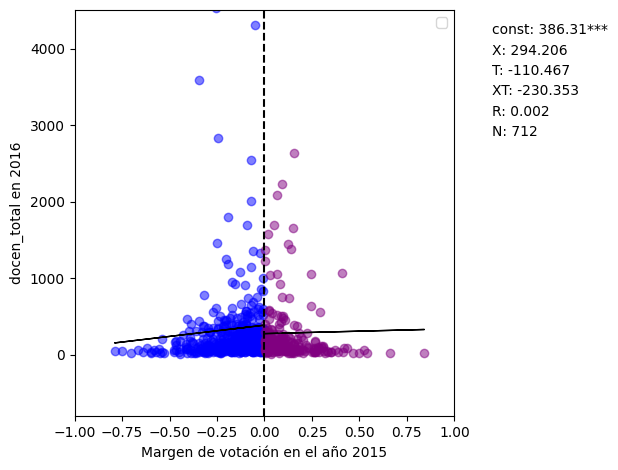

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


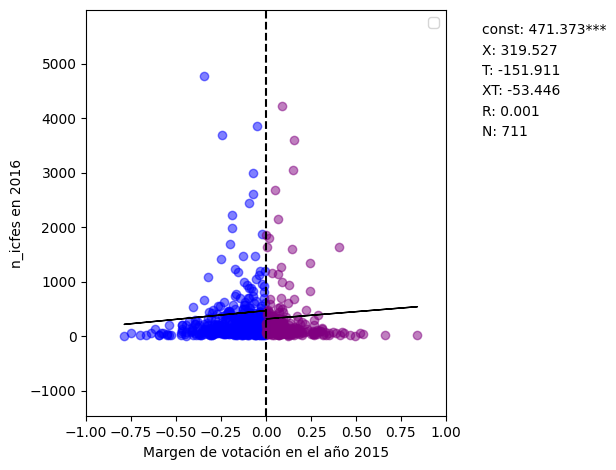

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


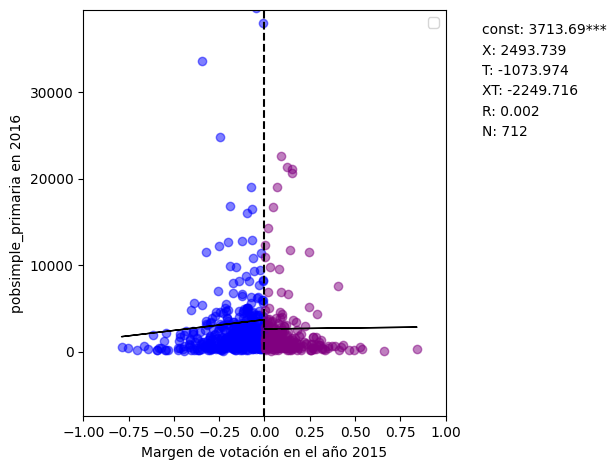

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


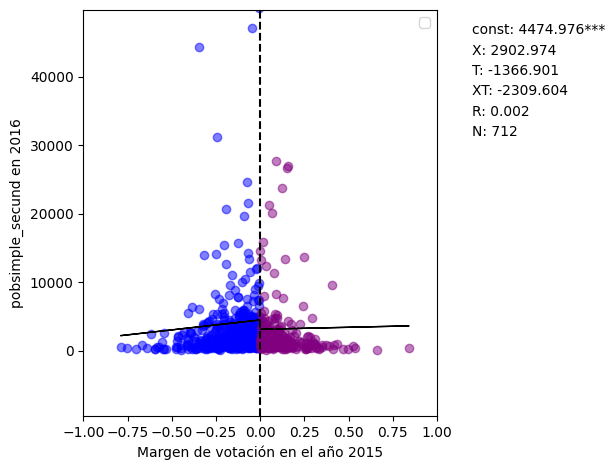

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


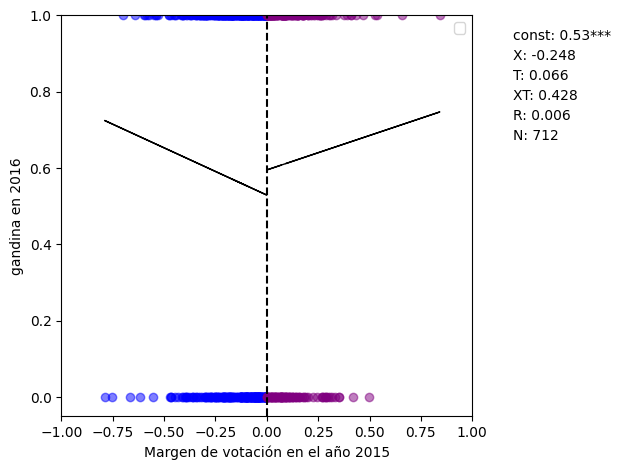

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


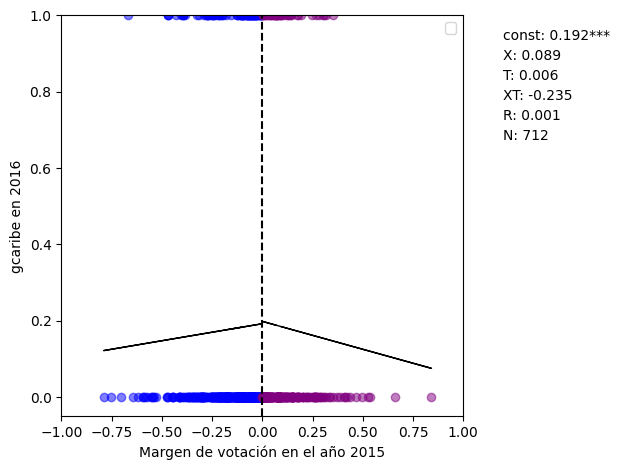

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


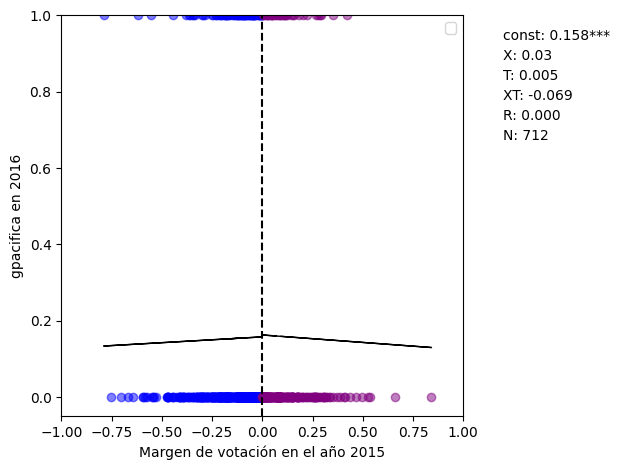

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


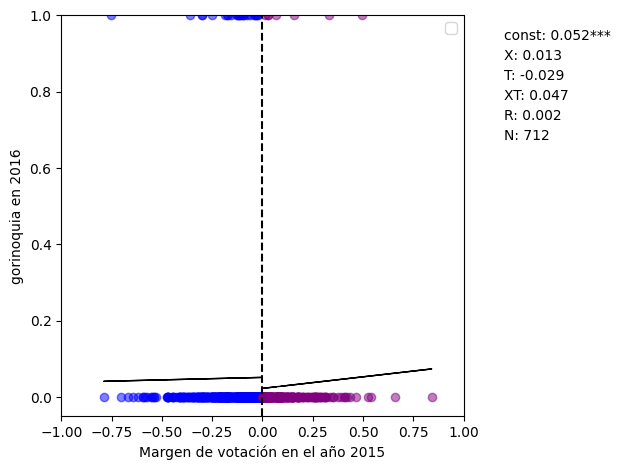

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


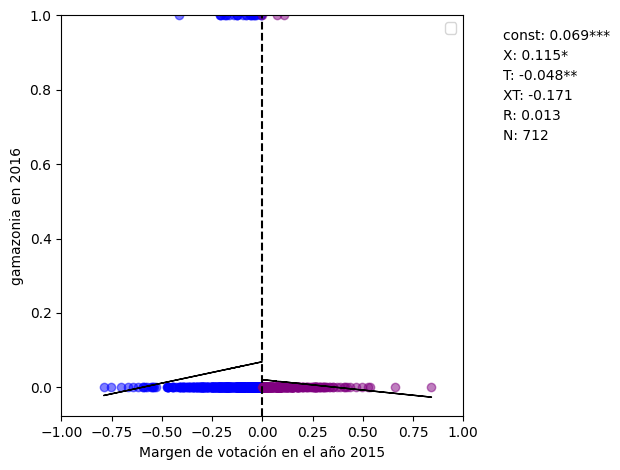

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


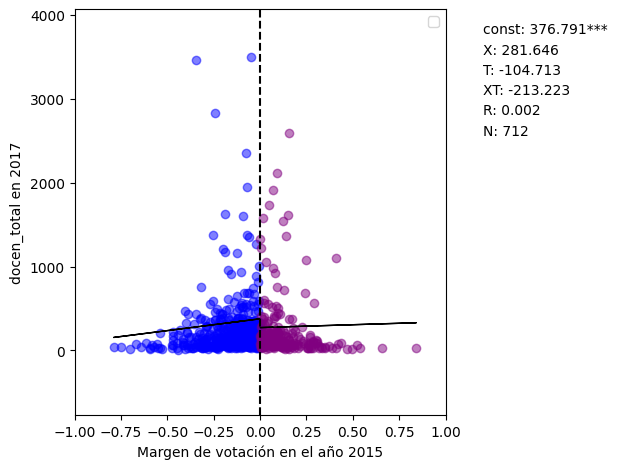

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


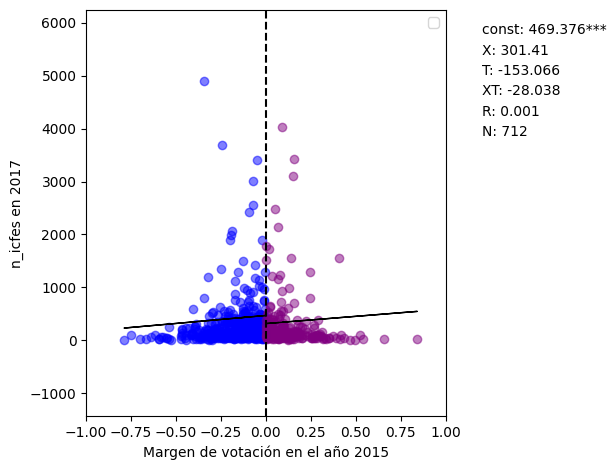

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


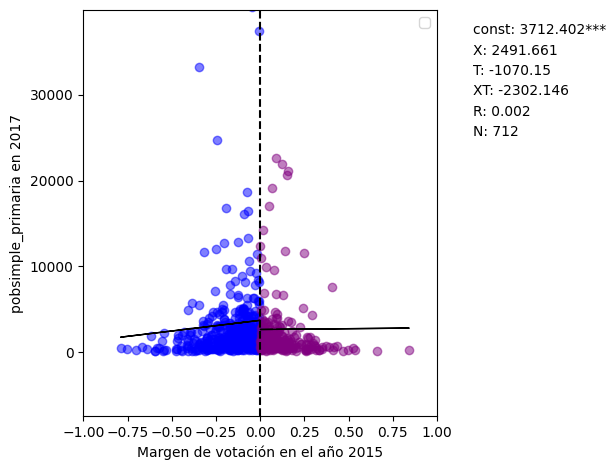

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


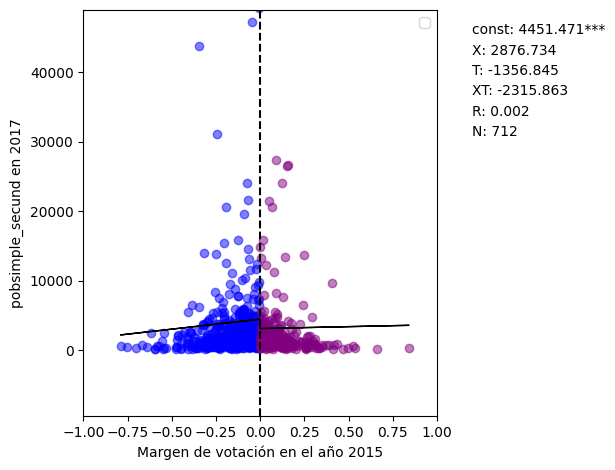

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


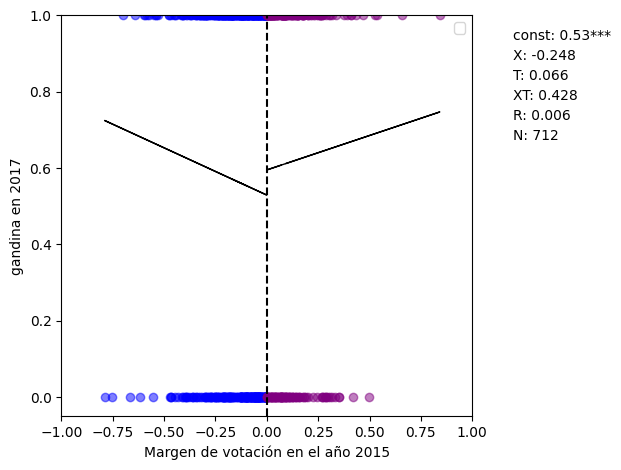

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


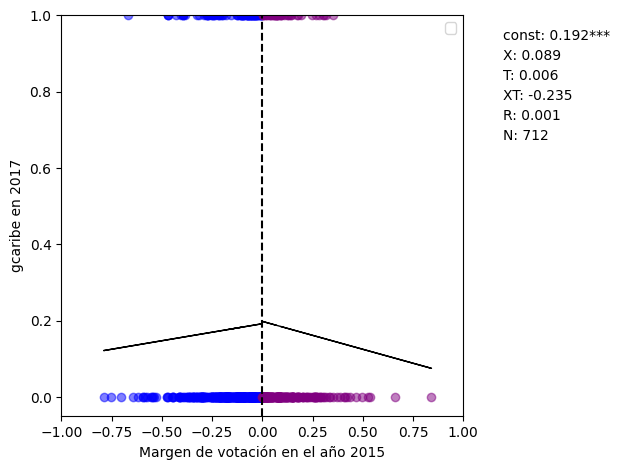

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


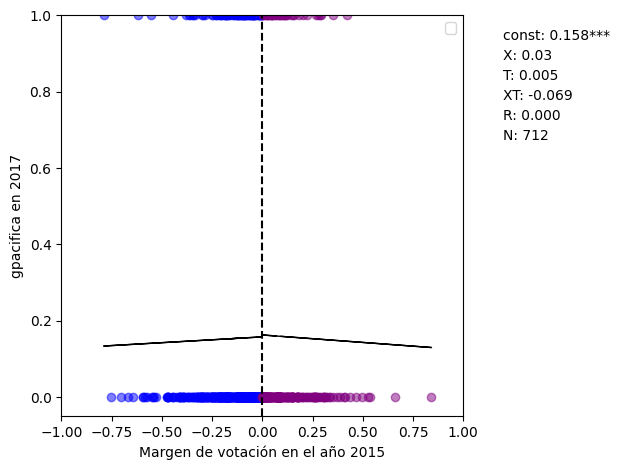

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


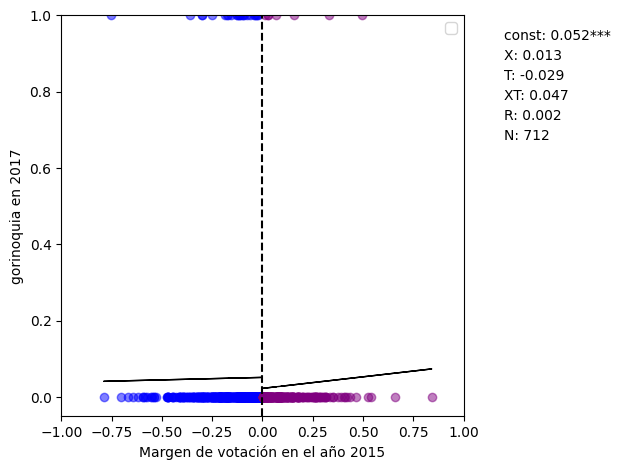

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


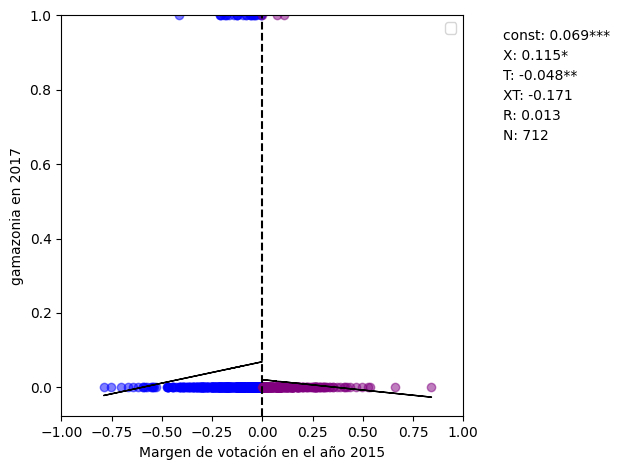

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


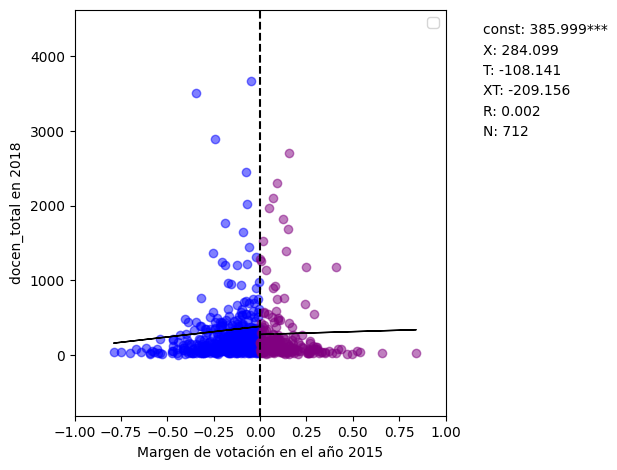

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


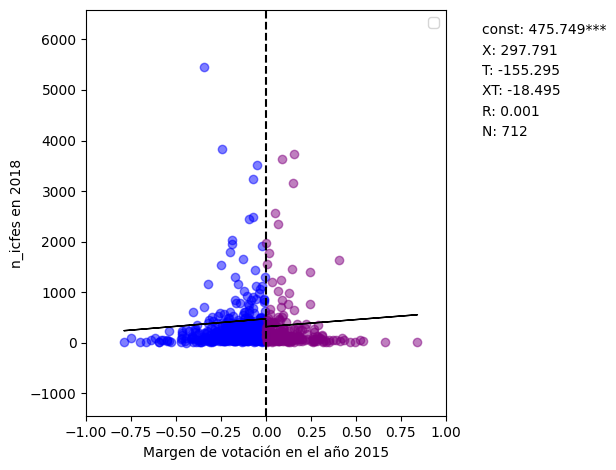

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


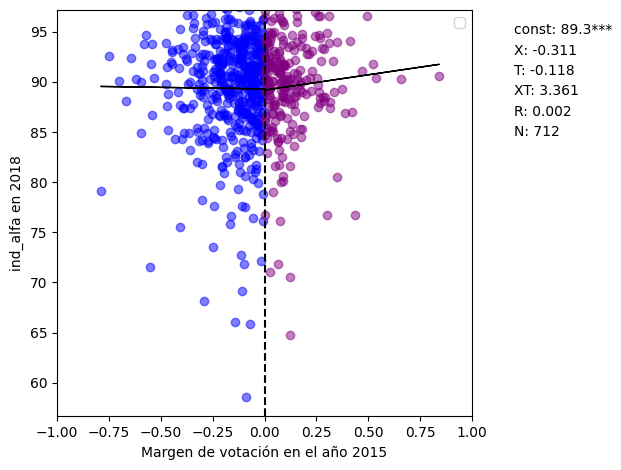

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


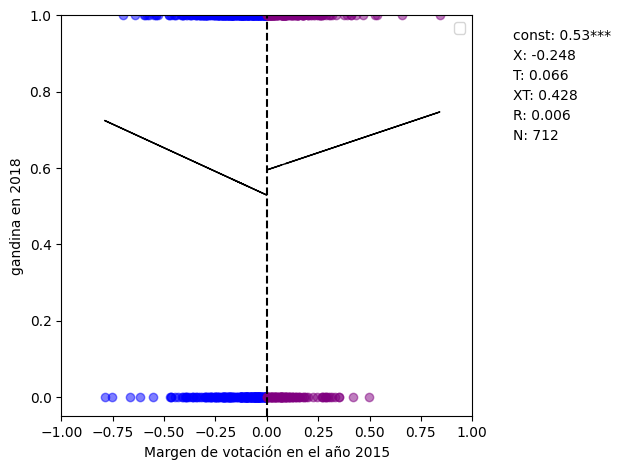

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


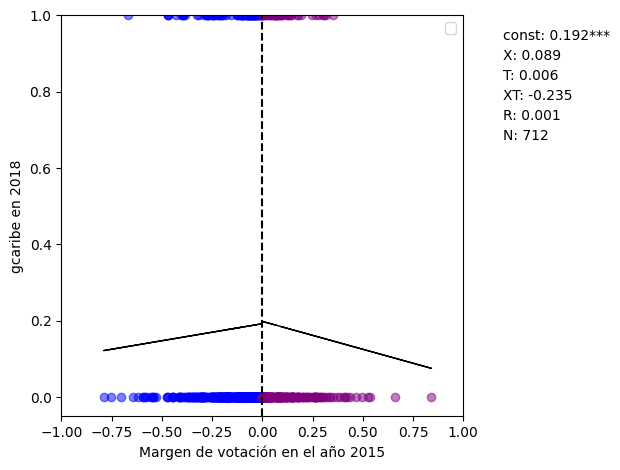

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


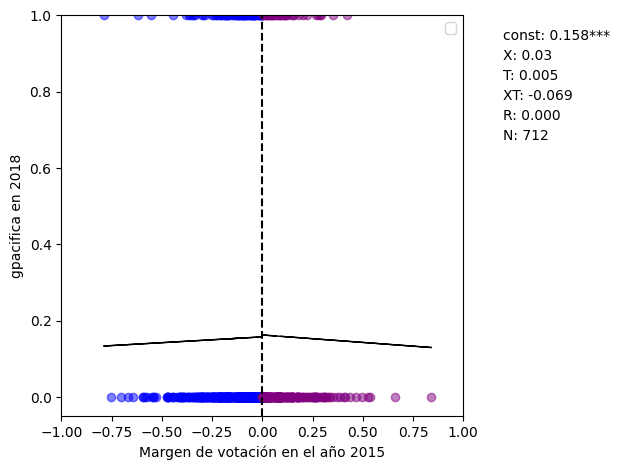

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


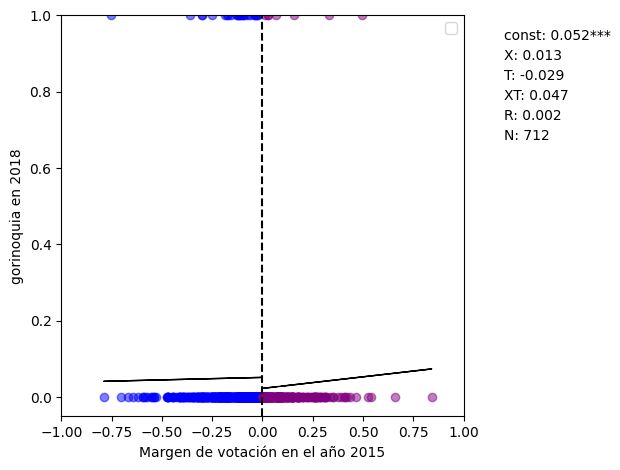

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


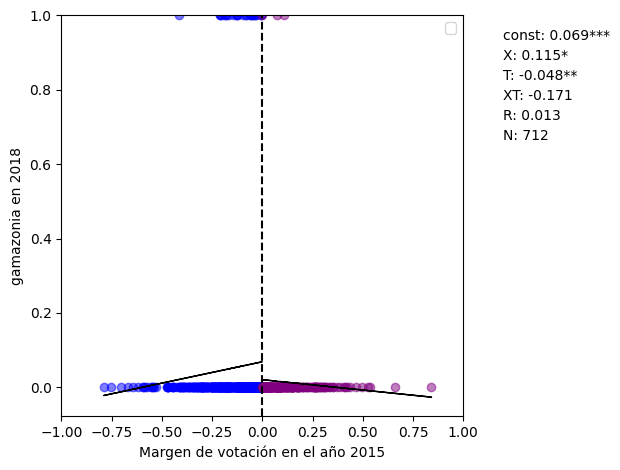

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


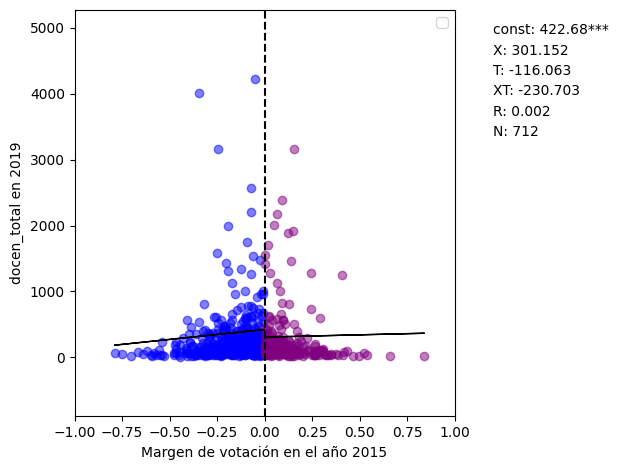

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


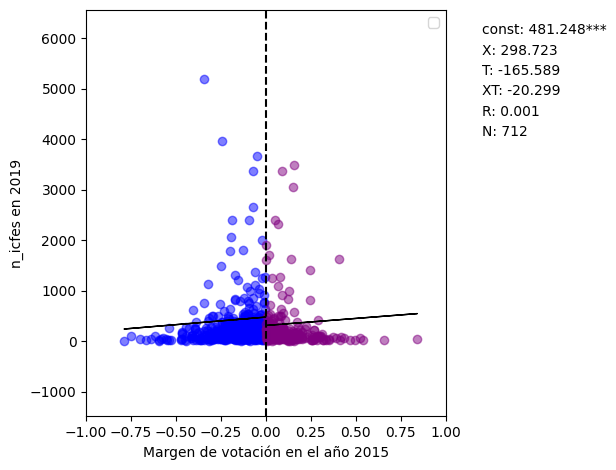

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


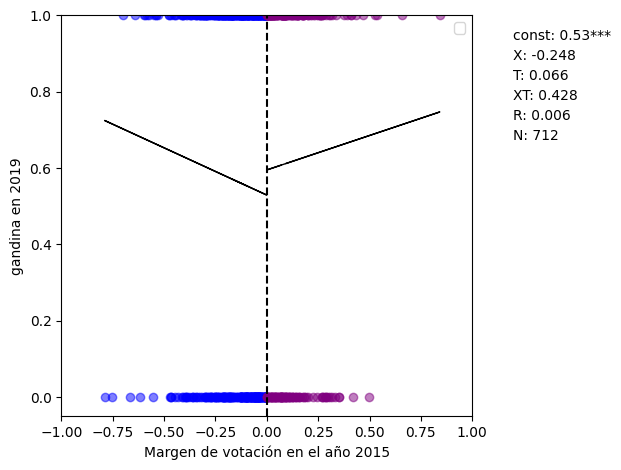

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


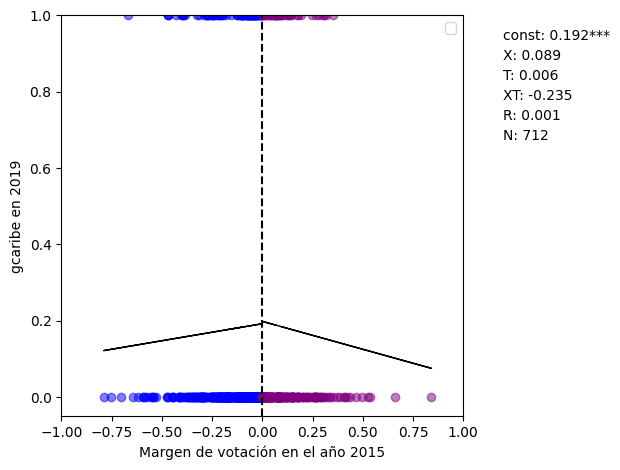

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


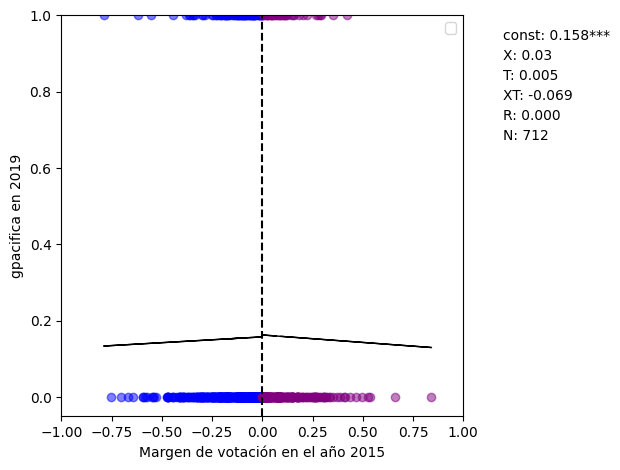

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


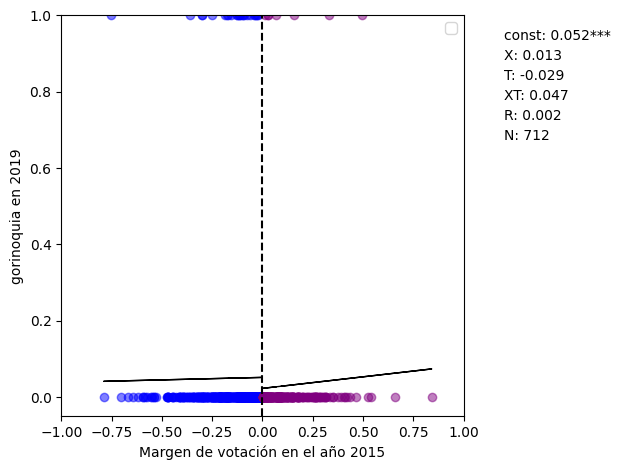

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


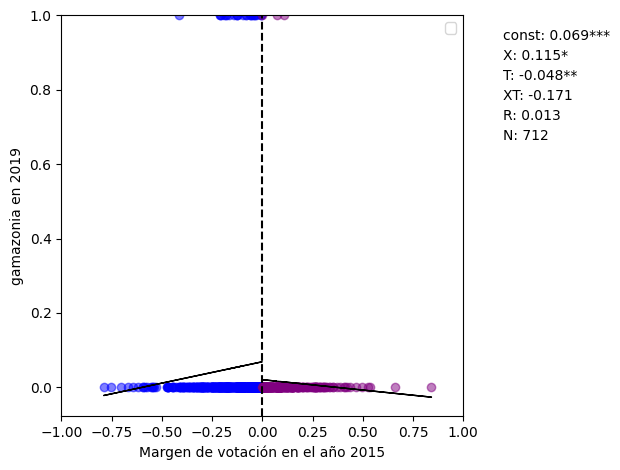

In [ ]:
for año in años_ev:
    for Y in dependientes_list:
        d = df[df.date == año]
        try:
            d["X"] = d[f"diferencia_{año_t1}"].copy()
            d["Y"] = d[Y]
            dd = d[[Y, "X"]].dropna()
            dd.columns = ["Y", "X"]
            dd = dd[np.abs(dd["X"])<=1]


            #VERIFICAR QUE ES EL MISMO COEFICIENTE
            dd['const'] = 1
            dd["T"] = dd["X"].apply(lambda x: 1 if x>=0 else 0)

            # Crear la interacción
            dd['XT'] = dd['X'] * dd['T']
            model = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']])
            results = model.fit()
            sumario = results.summary2()

            #LO MISMO PERO CON EL COMANDO RD-ROBUST
            est1 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "uniform", all = True, h = 100, vce='hc0')
            est2 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "triangular", all = True, h = 100, vce = "hc0")

            N = sumario.tables[0].iloc[3,1]
            R = sumario.tables[0].iloc[6,1]

            coef_df = sumario.tables[1].loc[:,["Coef.", "P>|t|"]]
            coef_df['P>|t|'] = coef_df['P>|t|'].apply(significance)
            coef_df["coef"] = coef_df.apply(lambda row: str(round(row["Coef."],3))+row["P>|t|"], axis = 1)
            coef_df = coef_df[["coef"]]
            coef_df.loc["R"] = R
            coef_df.loc["N"] = N

            p = sumario.tables[1].loc["XT","P>|t|"]

            if p>0.1:

                maxy = dd["Y"].quantile(0.99)
                miny = dd["Y"].quantile(0.00)
            
                # Generar las predicciones del modelo
                dd['y_pred'] = results.predict(dd[['const', 'X', 'T', 'XT']])

                # Separar los datos para antes y después del umbral
                before_threshold = dd[dd['X'] < 0]
                after_threshold = dd[dd['X'] >= 0]

                # Graficar los datos reales
                plt.scatter(before_threshold['X'], before_threshold['Y'], color='blue', alpha=0.5)
                plt.scatter(after_threshold['X'], after_threshold['Y'], color='purple', alpha=0.5)

                # Graficar las predicciones del modelo
                plt.plot(before_threshold['X'], before_threshold['y_pred'], color='black', linewidth=1)
                plt.plot(after_threshold['X'], after_threshold['y_pred'], color='black', linewidth=1)

                # Añadir línea vertical en X=0
                plt.axvline(x=0, color='black', linestyle='--')

                # Títulos y etiquetas
                # plt.title("Gráfica de la regresión discontinua")
                plt.xlabel(f"Margen de votación en el año {año_t1}")
                plt.ylabel(f"{Y} en {año}")
                plt.legend()
                plt.xlim(-1,1)

                plt.gca().set_ylim(top=maxy)

                # # Asumiendo que quieres poner la leyenda en la esquina superior derecha
                # x_position = 1.3 * np.abs(plt.xlim()[1])  # 60% a lo largo del eje x
                # y_position = 0.9 * np.abs(plt.ylim()[1])  # 90% a lo largo del eje y

                # # Usar un loop para escribir cada coeficiente en la gráfica
                # for index, row in coef_df.iterrows():
                #     coef_string = f"{index}: {row['coef']}"
                #     plt.text(x_position, y_position, coef_string, fontsize=10)
                #     y_position -= 0.1 * plt.ylim()[1]  # Esto moverá cada entrada un 10% hacia abajo en el eje y


                # Definir la posición inicial en la esquina superior derecha.
                # (1, 1) representa la esquina superior derecha del eje.
                x_position = 1.1  # Justo a la derecha del eje
                y_position = 0.95  # Cerca de la parte superior del eje

                # Espaciado vertical entre las entradas de la leyenda.
                y_spacing = 0.05

                # Usar un loop para escribir cada coeficiente en la gráfica
                for index, row in coef_df.iterrows():
                    coef_string = f"{index}: {row['coef']}"
                    
                    plt.annotate(coef_string, 
                                xy=(x_position, y_position), 
                                xycoords='axes fraction', 
                                fontsize=10,
                                horizontalalignment='left',
                                verticalalignment='center')

                    # Mover la posición y hacia abajo para la siguiente entrada
                    y_position -= y_spacing

                plt.tight_layout()
                plt.savefig(f"{carpeta}//ELECCIONES_{año_t1}_{Y}_{año}", bbox_inches='tight')

                plt.show()
        except:
            None

            

In [ ]:
# Mostrar la figura
# plt.figure(figsize=(10, 6))
# rddensity.rdplotdensity(rdd, RV)
# plt.show()

# import rddensity
# from rdrobust import rdrobust,rdbwselect,rdplot

# rdd = rddensity.rddensity(X=RV)
# rddensity.rdplotdensity(rdd, RV, plotN=[40])

## Test

In [ ]:
# Signature:
# rdplot(
#     y,
#     x,
#     c=0,
#     p=4,
#     nbins=None,
#     binselect='esmv',
#     scale=None,
#     kernel='uni',
#     weights=None,
#     h=None,
#     covs=None,
#     covs_eval='mean',
#     covs_drop=True,
#     support=None,
#     subset=None,
#     masspoints='adjust',
#     hide=False,
#     ci=None,
#     shade=False,
#     title=None,
#     x_label=None,
#     y_label=None,
#     x_lim=None,
#     y_lim=None,
#     col_dots=None,
#     col_lines=None,
# )

In [ ]:
# rdplot(y=dd["Y"], x=dd["X"], binselect="es", p = 1, nbins = 100)

In [ ]:
# rdd = rddensity.rddensity(X=dd["X"])
# rddensity.rdplotdensity(rdd, dd["X"])

# rddensity: default options
# repr(rddensity.rddensity(X=X, useall = True, fitselect="restricted", vce="plugin"))
# repr(rddensity.rdbwdensity(X=X)) #seleccionar bandwidth

# rdbwdensity: compute bandwidth and then use them
# bw = rddensity.rdbwdensity(X=data)
# hr = bw.h.iloc[1,0]
# print(repr(rddensity.rddensity(X=data, h=[10, hr])))

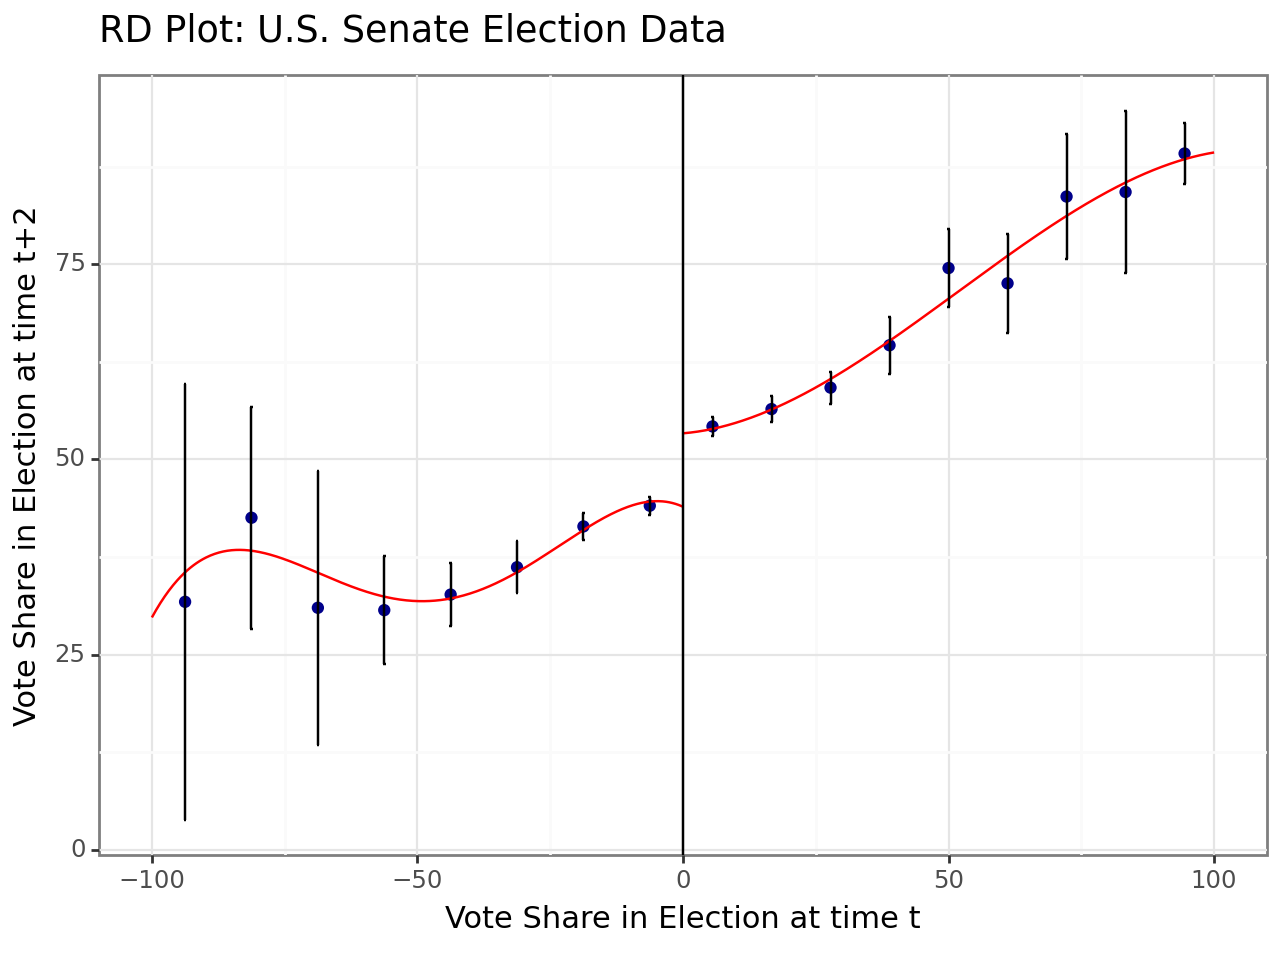

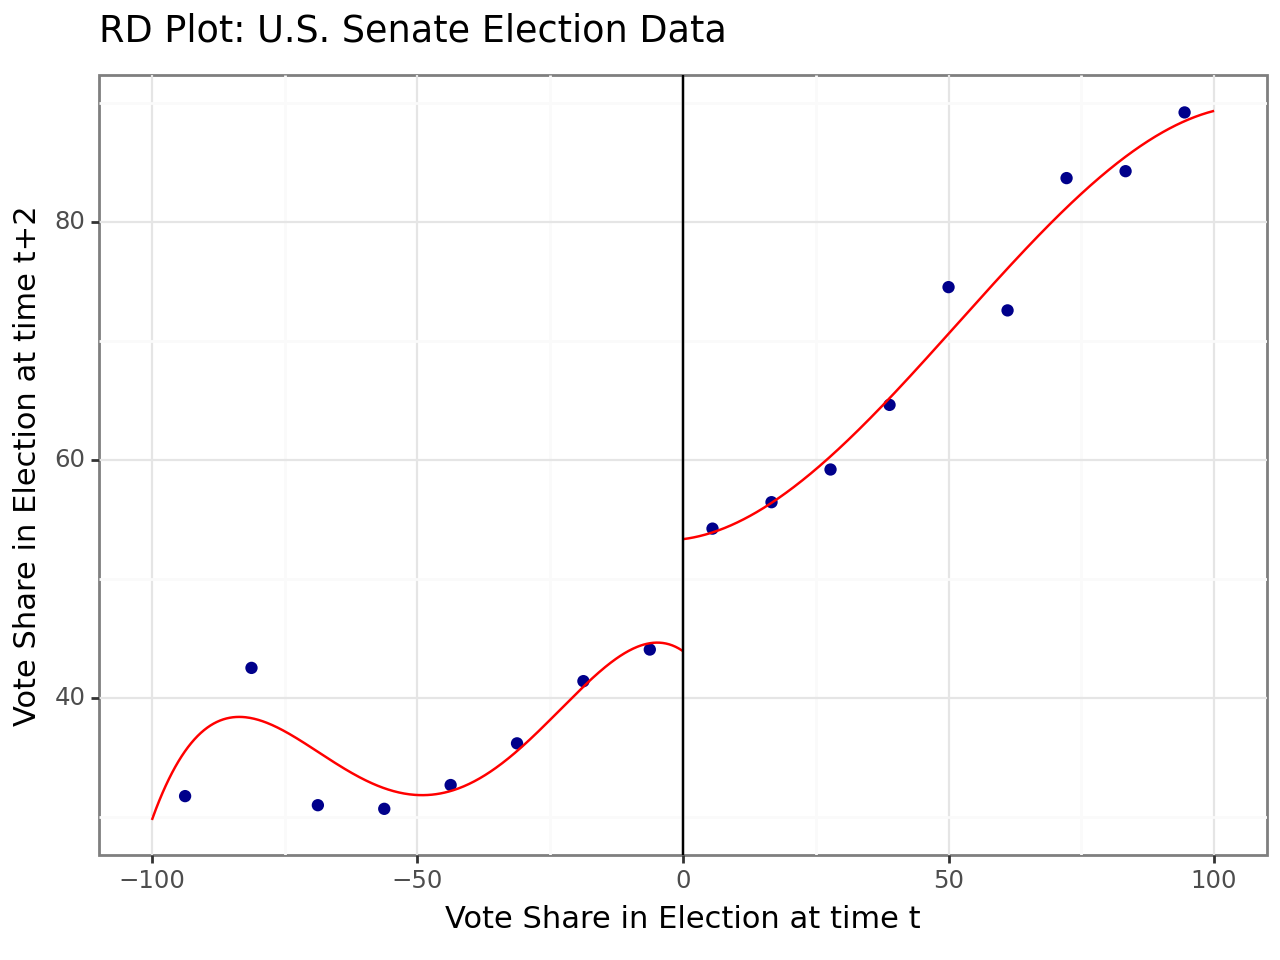

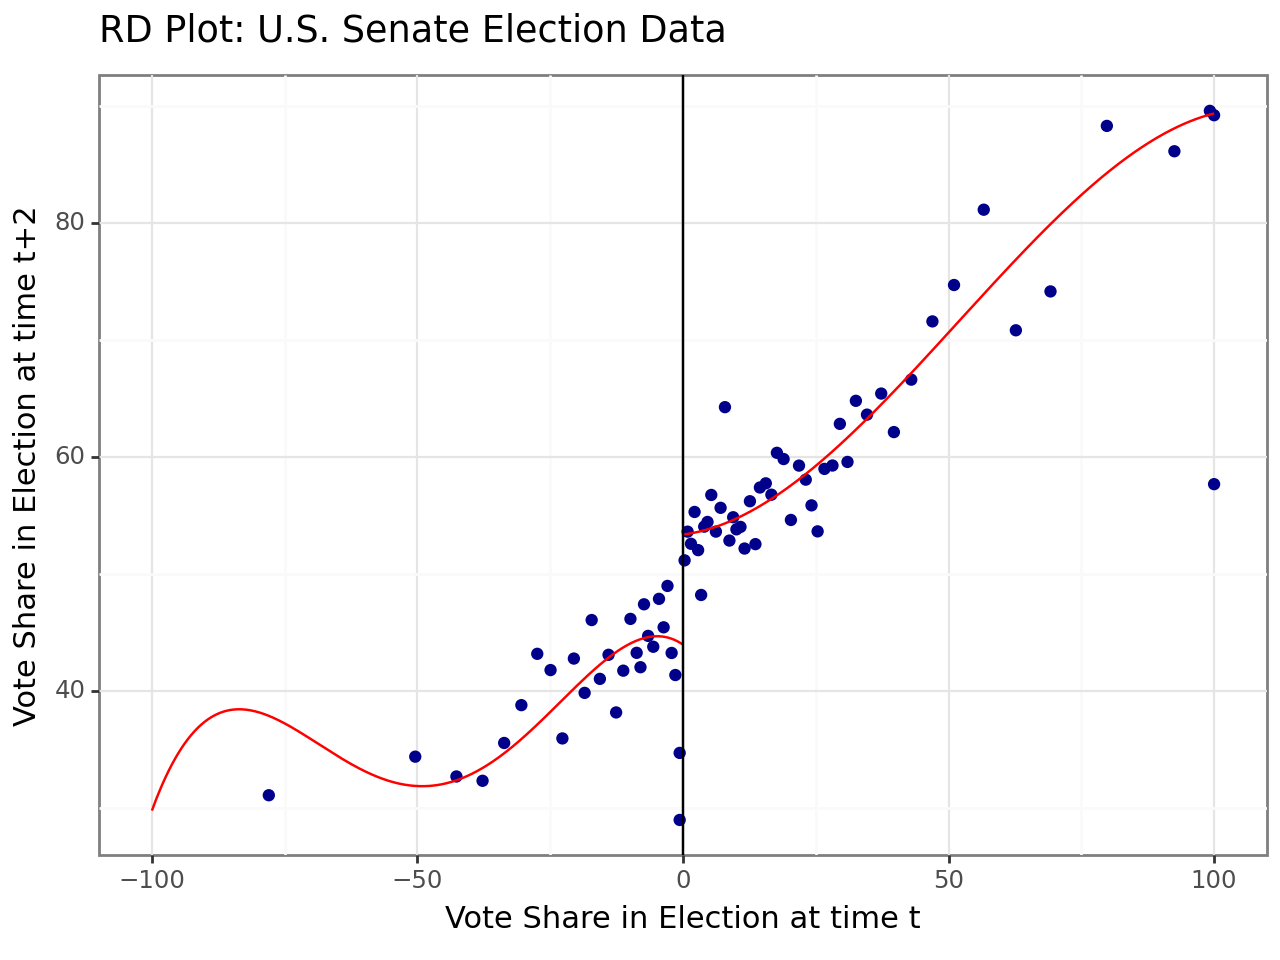


Call: rdrobust
Number of Observations:                  1297
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Unique Obs.            595        665
Number of Effective Obs.         360        323
Bandwidth Estimation          17.754     17.754
Bandwidth Bias                28.028     28.028
rho (h/b)                      0.633      0.633

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       7.414    1.459    5.083   3.722e-07    [4.555, 10.273]
Robust                 -        -    4.311   1.625e-05    [4.094, 10.919]

Call: rdrobust
Number of Ob

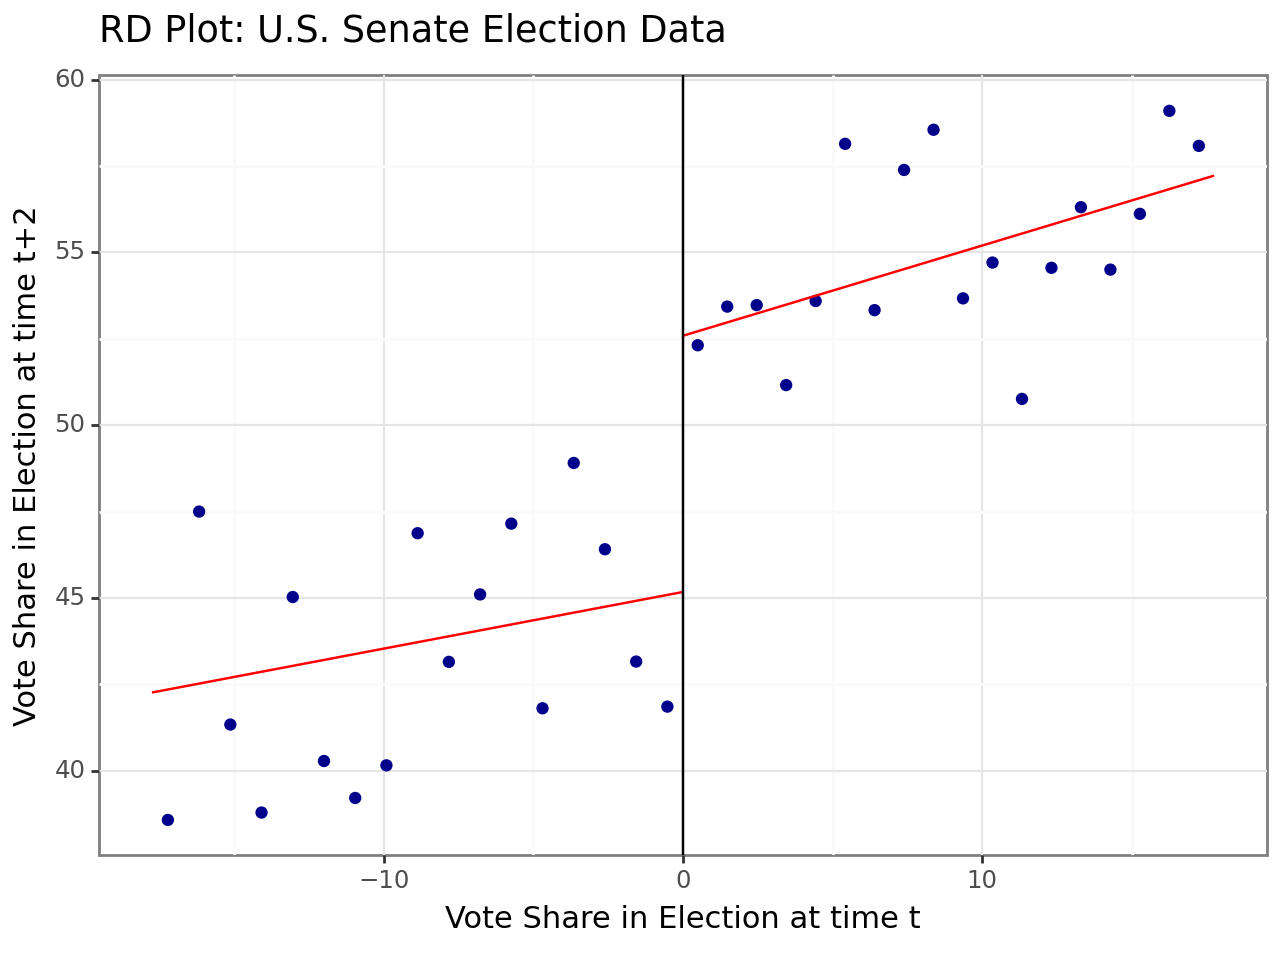


CI length change: -3.48%
CI length change: -4.46%
CI length change: 0.28%
                 RD Effect Robust p-val
class            -0.021338     0.896466
termshouse       -0.172574     0.561328
termssenate      -0.191764     0.900087
population  -318523.982883     0.633988
Call: rdrobust
Number of Observations:                  1297
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Unique Obs.            595        665
Number of Effective Obs.         359        320
Bandwidth Estimation          17.577     17.577
Bandwidth Bias                27.095     27.095
rho (h/b)                      0.649      0.649

Method             Coef.     S.E.   t-stat    P

In [ ]:
###########################################################################
## RDROBUST Python Package
## Script for Empirical Illustration
## Authors: Sebastian Calonico, Matias D. Cattaneo,
##          Max H. Farrell, Ricardo Masini and Rocio Titiunik 
###########################################################################

### Load RDROBUST package
from rdrobust import rdrobust,rdbwselect,rdplot
import pandas as pd

### Load data base
rdrobust_senate = pd.read_csv("rdrobust_senate.csv")

# Define the variblrs
margin = rdrobust_senate.margin
vote = rdrobust_senate.vote

### rdplot with 95% confidence intervals
rdplot(y=vote, x=margin, binselect="es", ci=95, 
         title="RD Plot: U.S. Senate Election Data", 
         y_label="Vote Share in Election at time t+2",
         x_label="Vote Share in Election at time t")

### rdplot with MSE-optimal choice
rdplot(y=vote, x=margin, binselect="es", 
       title="RD Plot: U.S. Senate Election Data", 
       y_label="Vote Share in Election at time t+2",
       x_label="Vote Share in Election at time t")

### rdplot with QS partitioning and mimicking variance choice
rdplot(y=vote, x=margin, binselect="qsmv", 
       title="RD Plot: U.S. Senate Election Data", 
       y_label="Vote Share in Election at time t+2",
       x_label="Vote Share in Election at time t")

### rdrobust 
print(rdrobust(y=vote, x=margin))

### rdrobust with all estimates
print(rdrobust(y=vote, x=margin, all=True))

## rdrobust backward compatibility
print(rdrobust(y=vote, x=margin, h=16.79369, b=27.43745))

## rdplot to show rdrobust estimate
est = rdrobust(y=vote, x=margin)
h_l, h_r = est.bws.loc['h', :].values
subset = ((-h_l<= margin) & (margin <= h_r)).values

rdplot(y=vote, x=margin, subset=subset,
       binselect="esmv", kernel="triangular", h=[h_l,h_r], p=1,
       title="RD Plot: U.S. Senate Election Data", 
       y_label="Vote Share in Election at time t+2",
       x_label="Vote Share in Election at time t")

## rdrobust with covariates within the same window (i.e., using same bandwidths)
est1 = rdrobust(y=vote, x=margin)
len1 = est1.ci.iloc[2,1] - est1.ci.iloc[2,0]
covs = rdrobust_senate[['class','termshouse','termssenate']]
b_l, b_r = est.bws.loc['b', :].values
est2 = rdrobust(y=vote, x=margin, covs=covs, 
                 h = [h_l,h_r], 
                 b = [b_l,b_r])
len2 = est2.ci.iloc[2,1] - est2.ci.iloc[2,0]
print("CI length change: " + str(round((len2/len1-1)*100,2)) + "%")

## rdrobust with covariates with data-driven optimal bandwidths
est1 = rdrobust(y=vote, x=margin)
len1 = est1.ci.iloc[2,1] - est1.ci.iloc[2,0]
est2 = rdrobust(y=vote, x=margin, covs=covs)
len2 = est2.ci.iloc[2,1] - est2.ci.iloc[2,0]
print("CI length change: " + str(round((len2/len1-1)*100,2)) + "%")

## rdrobust with useless covariate
est1 = rdrobust(y=vote, x=margin)
len1 = est1.ci.iloc[2,1] - est1.ci.iloc[2,0]
covs = rdrobust_senate['population']
est2 = rdrobust(y=vote, x=margin, covs=covs)
len2 = est2.ci.iloc[2,1] - est2.ci.iloc[2,0]
print("CI length change: " +  str(round((len2/len1-1)*100,2))+ "%")

## rdrobust check covariate "balanced"
covs = rdrobust_senate[['class','termshouse','termssenate','population']]
balance = pd.DataFrame(columns = ["RD Effect", "Robust p-val"],
                       index = pd.Index(["class","termshouse", "termssenate", "population"]))
for z in covs.columns:
    est = rdrobust(y=covs[z], x=margin)
    balance.loc[z,"RD Effect"] = est.Estimate["tau.us"].values[0]
    balance.loc[z,"Robust p-val"] = est.pv.iloc[2].values[0]
    
print(balance)

## rdrobust with clustering
state =rdrobust_senate.state.values
print(rdrobust(y=vote, x=margin, vce="nn", cluster=state))

## rdrobust with clustering and covariates, and different bandwidth
covs = rdrobust_senate[['class','termshouse','termssenate']]
print(rdrobust(y=vote, x=margin, vce="nn", bwselect="msetwo", covs=covs, cluster=state))

## rdbwselect with all estimates
print(rdbwselect(y=vote, x=margin, all=True))

## Other examples
print(rdrobust(y=vote, x=margin, kernel="uniform", vce="hc1", cluster=state))
print(rdrobust(y=vote, x=margin, bwselect="certwo", vce="hc3"))
print(rdrobust(y=vote, x=margin, h=(12,15), b=(18,20)))
print(rdrobust(y=vote, x=margin, covs=rdrobust_senate['class'], bwselect="cerrd", scaleregul=0, rho=1))
print(rdbwselect(y=vote, x=margin, kernel="uniform", vce="hc1", cluster=state, all=True))
print(rdbwselect(y=vote, x=margin, covs=rdrobust_senate['class'], bwselect="msetwo", vce="hc2", all=True))

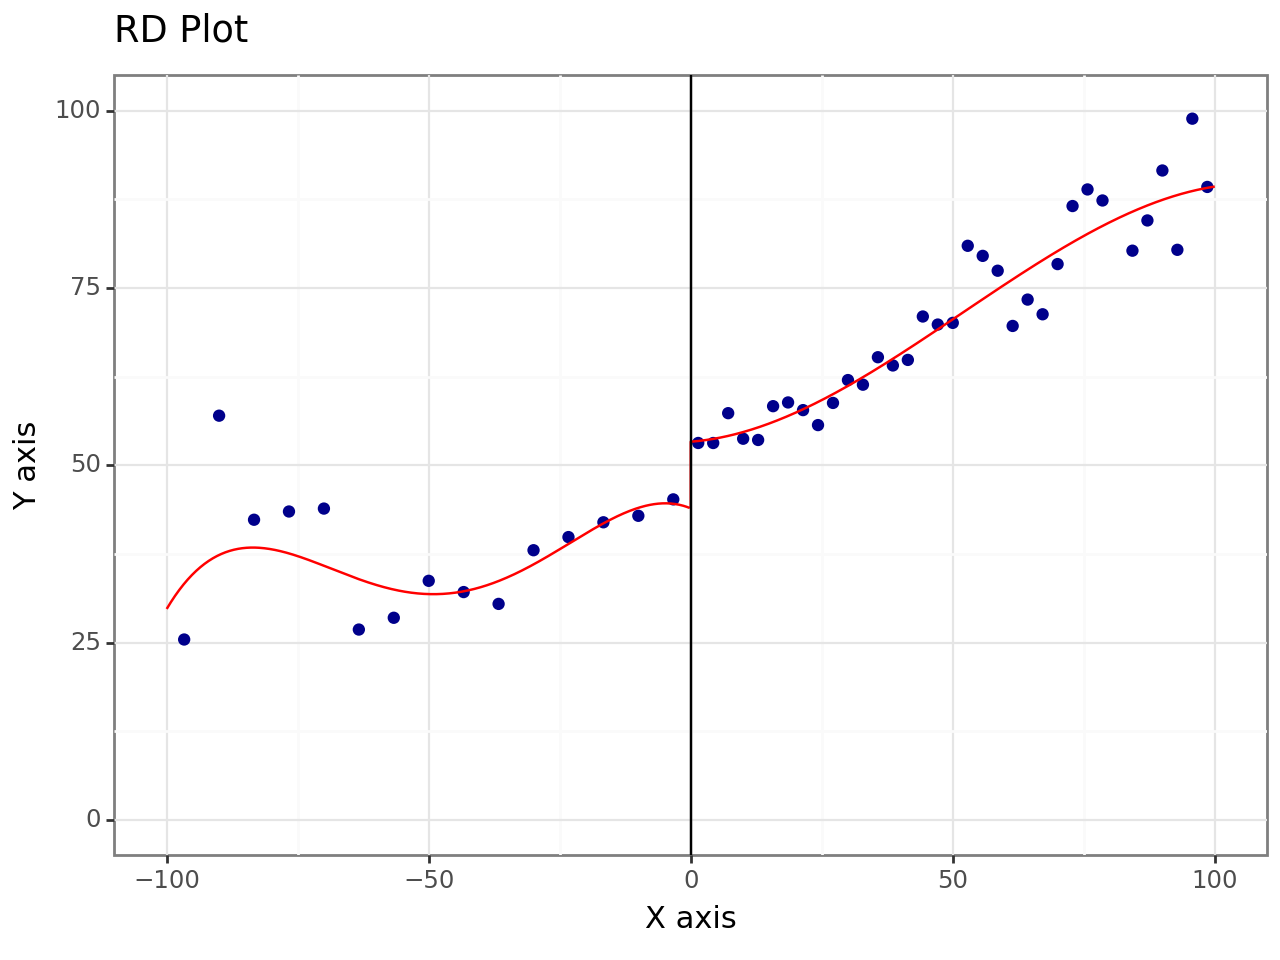

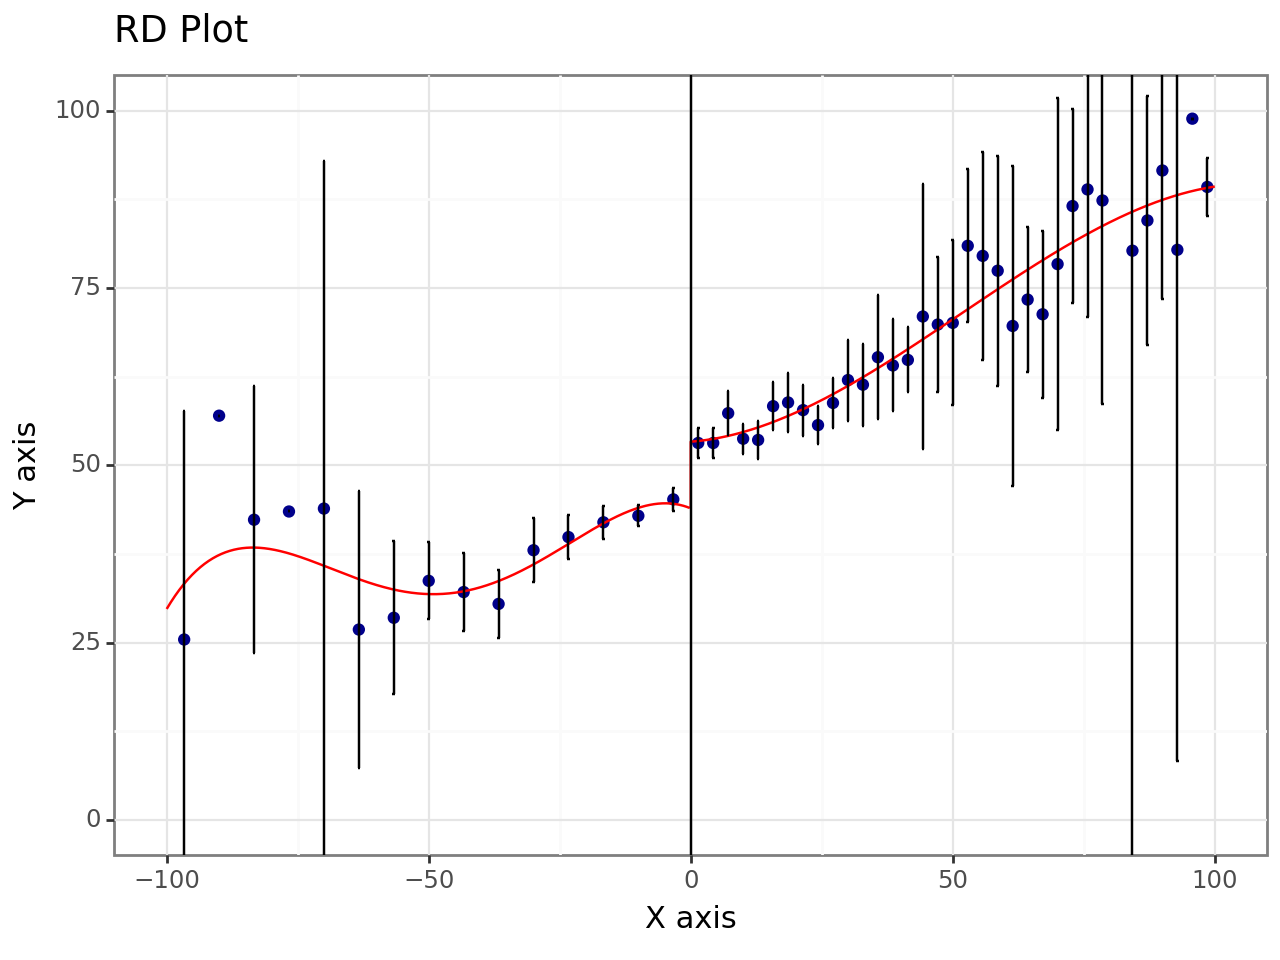

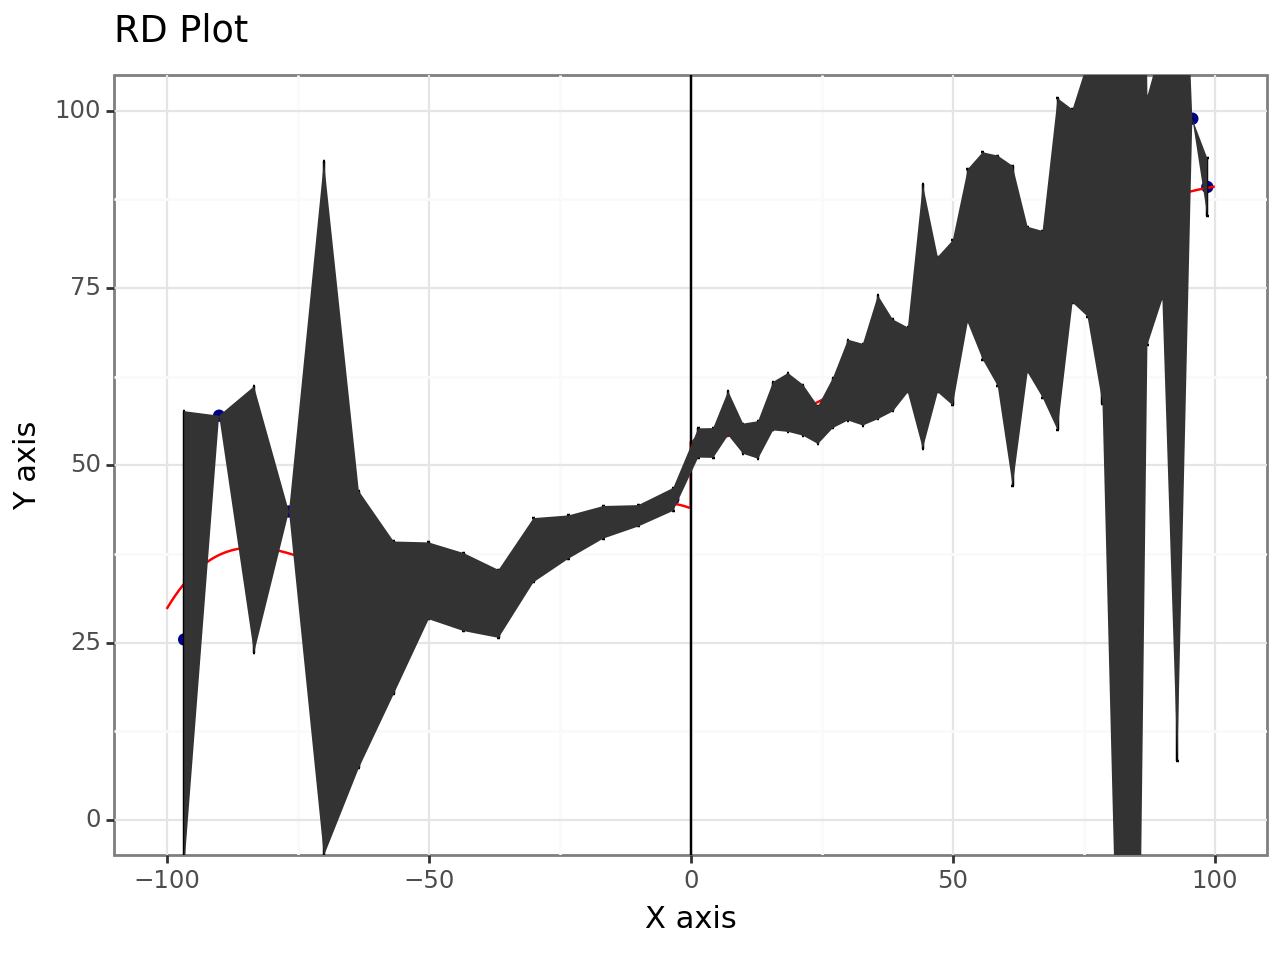

In [ ]:
###########################################################################
## RDROBUST Python Package
## Python Script for Empirical Illustration
## Authors: Sebastian Calonico, Matias D. Cattaneo,
#           Max H. Farrell, Ricardo Masini and Rocio Titiunik 
###########################################################################

### Impot rdrobust package
from rdrobust import rdplot
import pandas as pd
from plotnine import *

### Load Data
df = pd.read_csv('rdrobust_senate.csv')
x = df.margin
y = df.vote
c = 0

###########################################################################
# Generate input data for output plot
###########################################################################
plot1 = rdplot(y,x, ci=95, hide=True)
rdplot_mean_bin = plot1.vars_bins["rdplot_mean_bin"]
rdplot_mean_y   = plot1.vars_bins["rdplot_mean_y"]
y_hat           = plot1.vars_poly["rdplot_y"]
x_plot          = plot1.vars_poly["rdplot_x"]
rdplot_cil_bin  = plot1.vars_bins["rdplot_ci_l"]
rdplot_cir_bin  = plot1.vars_bins["rdplot_ci_r"]
rdplot_mean_bin = plot1.vars_bins["rdplot_mean_bin"]
y_hat_r = y_hat[x_plot>=c]
y_hat_l = y_hat[x_plot<c]
x_plot_r = x_plot[x_plot>=c]
x_plot_l = x_plot[x_plot<c]


col_lines = "red"
col_dots  = "darkblue"
type_dots = 20
title = "RD Plot"
x_label = "X axis"
y_label = "Y axis"
x_lim = (min(x),max(x))
y_lim = (min(y), max(y))

###########################################################################
# Generate rdplot using ggplot2
###########################################################################
temp_plot = (ggplot() + theme_bw() +

                    geom_point(aes(x=rdplot_mean_bin, y=rdplot_mean_y), color=col_dots, na_rm=True) +
                    geom_line(aes(x=x_plot_l, y=y_hat_l), color=col_lines, na_rm=True) +
                    geom_line(aes(x=x_plot_r, y=y_hat_r), color=col_lines, na_rm=True) +
                    labs(x = x_label, y = y_label) + ggtitle(title) +
                    labs(title = title, y = y_label, x = x_label) +
                    coord_cartesian(xlim = x_lim, ylim = y_lim) +
                    theme(legend_position = "None") +
                    geom_vline(xintercept = c, size = 0.5))
print(temp_plot)

## Add confidence intervals 
temp_plot = temp_plot + geom_errorbar(aes(x = rdplot_mean_bin, ymin = rdplot_cil_bin, ymax = rdplot_cir_bin)) 
print(temp_plot)

# Shade
temp_plot = temp_plot + geom_ribbon(aes(x = rdplot_mean_bin, ymin = rdplot_cil_bin, ymax = rdplot_cir_bin))
print(temp_plot)